# **Proyecto MOS - Etapa 2**

In [47]:
!pip install networkx matplotlib
!pip install haversine folium
!pip install seaborn
!pip install amplpy pyomo -q
!python -m amplpy.modules install coin highs scip gcg -q

from pyomo.environ import *
from haversine import haversine
import pandas as pd
import folium
from amplpy import modules
import matplotlib.pyplot as plt
import requests
import itertools

## **Modelo Matemático**

### **Suposiciones**
* La demanda de los clientes y la capacidad de los centros de distribución estan en las mismas unidades.
* Para los casos a resolver, los nodos no están concentrados en un único sector.
* Los vehículos deben cargar inventario desde algún centro de distribución al comenzar la jornada y deben regresar a algún centro de distribución al finalizarla.

### **Conjuntos**
* $C$: Conjunto de clientes.
* $D$: Conjunto de centros de distribución.
* $V$: Conjunto de vehículos.
* $A \subseteq (C \cup D) \times (C \cup D)$: Conjunto de arcos posibles entre nodos.

### **Parámetros**
* $cap_d$: Capacidad máxima del centro de distribución $d \in D$.
* $cap_v$: Capacidad útil de carga del vehículo $v \in V$.
* $rang_v$: Rango útil (en km) del vehículo $v \in V$.
* $dem_c$: Demanda del cliente $c \in C$.
* $dist_{ij}$: Distancia entre nodo $i$ y nodo $j$, para $(i,j) \in A$.
* $Pf$: Precio del combustible por litro (COP/l).
* $Ft$: Tarifa de flete por kilómetro recorrido (COP/km).
* $Cm$: Costo de mantenimiento por kilómetro recorrido (COP/km).
* $RC$: Rendimiento del combustible (l/km)


### **Variables de decisión**
* $x_{ijv} \in \{0,1\}$: 1 si el vehículo $v$ recorre el arco $(i,j)$, 0 en caso contrario.
* $u_{iv} \leq |(C \cup D)| - 1$: Variable auxiliar para la prevencion de sub-tours.



### **Función objetivo**
Minimizar el costo total de operación

$$\min \sum_{v \in V} \sum_{(i,j) \in A} x_{ijv} \cdot dist_{ij} \cdot (Ft + Cm + (RC \cdot Pf))$$

### **Restricciones**

Capacidad de centros de distribución:
* $\sum_{i \in C} \sum_{v \in V} x_{div}\cdot dem_c \leq cap_d \quad \forall d \in D$

Capacidad de vehículos:
* $\sum_{(i, c) \in A} x_{icv}\cdot dem_{c} \leq cap_v \quad \forall v \in V\  | \ c \in C$

Todos los clientes deben ser visitados:
* $\sum_{v \in V}\sum_{i \in C U D} x_{icv} = 1 \quad \forall c \in C$

Autonomía de vehículos:
* $\sum_{(i,j) \in A} dist_{ij} \cdot x_{ijv} \leq rang_v \quad \forall v \in V$

Un solo vehículo por salida de centro de distribucion:
* $\sum_{c \in C} \sum_{d \in D} x_{dcv} \leq 1, \forall v \in V$

Conservación del flujo para los nodos intermedios(flujo balanceado por nodo):
* $\sum_{j: (i,j) \in A} x_{ijv} - \sum_{j: (j,i) \in A} x_{jiv} = 0 \quad \forall i \in C, \forall v \in V$

Un solo vehículo por llegada al centro de distribucion:
* $\sum_{c \in C} \sum_{d \in D} x_{cdv} \leq 1, \forall v \in V$

Eliminación de Sub-Tours:
* $u_{iv} - u_{jv} + |(C \cup D)| \cdot x_{ijv} \leq |(C \cup D)| - 1 \quad \forall i,j \in C, v \in V, i \neq j\quad$

Llegada de cada vehículo a un único centro de distribución:
* $\sum_{c \in C} \sum_{d \in D} x_{cdv} \geq 1, \forall v \in V$


## **Procesamiento de Datos**

### **Módulo de Preprocesamiento: Cálculo de Matriz de Distancias**

#### **Función: `calcular_distancias_osrm(centros, clientes)`**

##### **Objetivo**

Construir una matriz de distancias entre todos los nodos (centros de distribución y clientes), utilizando la API pública de Open Source Routing Machine (OSRM). Esta matriz es esencial para alimentar el parámetro `dist_{ij}` en el modelo matemático, representando las distancias reales (no euclidianas) en kilómetros entre los puntos de entrega y abastecimiento.

##### **Entradas**

* `centros`: Diccionario con claves como identificadores de los centros de distribución y valores tipo `dict` con coordenadas (`lat`, `lon`).
* `clientes`: Diccionario con claves como identificadores de los clientes y valores tipo `dict` con coordenadas (`lat`, `lon`).

##### **Proceso**

1. Se construye una lista `nodos` que contiene todos los identificadores de nodos (centros y clientes).
2. Se genera un índice `idx` que asigna una posición entera a cada nodo para facilitar el acceso a la matriz devuelta por OSRM.
3. Se genera `coord_list`, una lista de coordenadas en formato `lon,lat`, ordenadas según `nodos`.
4. Se realiza una solicitud a la API de OSRM (`/table/v1/driving/`) para obtener la matriz de distancias entre todos los pares de nodos.
5. La respuesta contiene la matriz de distancias en metros, que se convierte a kilómetros dividiendo por 1000.
6. Se crea un diccionario `dist` con claves `(i, j)` representando pares de nodos y valores como la distancia en kilómetros, excluyendo los pares donde `i == j`.

##### **Salidas**

* `dist`: Diccionario de distancias reales entre nodos en kilómetros, en el formato `{(i, j): distancia_km}` para todos los `i ≠ j`.

##### **Dependencias**

* `requests`: Para realizar la solicitud HTTP a la API de OSRM.
* `itertools`: Para generar combinaciones de nodos.

##### **Consideraciones**

* La función asume que todos los nodos tienen coordenadas válidas.
* En caso de fallo en la API, `raise_for_status()` genera una excepción automática, lo que ayuda a depurar problemas de conectividad o formato.

##### **Uso esperado**

Esta función debe ser ejecutada antes de la construcción del modelo Pyomo, y su salida debe usarse para inicializar el parámetro `model.dist`.

In [48]:
def calcular_distancias_osrm(centros, clientes):
    nodos = list(centros.keys()) + list(clientes.keys())
    idx = {n: i for i, n in enumerate(nodos)}

    coord_list = []
    for n in nodos:
        if n in centros:
            lat, lon = centros[n]['lat'], centros[n]['lon']
        else:
            lat, lon = clientes[n]['lat'], clientes[n]['lon']
        coord_list.append(f"{lon},{lat}")
    
    coords_str = ";".join(coord_list)

    url = f"http://router.project-osrm.org/table/v1/driving/{coords_str}?annotations=distance"
    resp = requests.get(url)
    resp.raise_for_status()
    data = resp.json()
    mat = data["distances"]

    dist = {}
    for i, j in itertools.product(nodos, repeat=2):
        if i != j:
            dist[i, j] = mat[idx[i]][idx[j]] / 1000.0  # km
    
    return dist


#### **Función de Apoyo: `get_route_info(lat1, lon1, lat2, lon2)`**

##### **Objetivo**

Obtener información detallada de una ruta óptima entre dos puntos geográficos mediante la API de OSRM, incluyendo la distancia real y la geometría del trayecto para su posterior visualización. En caso de error o indisponibilidad del servicio, se calcula una distancia aproximada usando la fórmula de Haversine como respaldo.


##### **Entradas**

* `lat1`, `lon1`: Coordenadas del punto de partida (latitud y longitud en grados).
* `lat2`, `lon2`: Coordenadas del punto de destino (latitud y longitud en grados).

##### **Proceso**

1. Se construye la URL de consulta hacia la API pública de OSRM (`/route/v1/driving/`), solicitando la geometría completa del trayecto en formato GeoJSON.
2. Se realiza la solicitud HTTP y se procesa la respuesta:

   * Si la API responde correctamente y contiene rutas:

     * Se extrae la distancia total del trayecto (en metros, convertida a kilómetros).
     * Se convierte la geometría del trayecto (en formato `[lon, lat]`) a una polilínea con formato `[lat, lon]`, útil para bibliotecas de visualización como Folium o Leaflet.
3. En caso de error (fallo de red, error de API o ausencia de rutas válidas), se ejecuta una rutina de respaldo:

   * Se calcula la distancia aproximada mediante la fórmula **Haversine**.
   * Se devuelve una polilínea simple entre los dos puntos como ruta recta.

##### **Salidas**

* `distance`: Distancia total de la ruta en kilómetros (`float`).
* `polyline`: Lista de coordenadas `[lat, lon]` que representan la trayectoria para trazado en mapas.

##### **Dependencias**

* `requests`: Para realizar la solicitud HTTP a OSRM.
* `math`: Para cálculos trigonométricos en la fórmula de Haversine.
* Requiere que la función `haversine(p1, p2)` esté definida externamente.

##### **Uso esperado**

* Esta función se usa en la etapa de visualización de rutas de vehículos en mapas interactivos (como Folium).
* También puede utilizarse para verificar rutas específicas entre centros de distribución y clientes seleccionados.


In [49]:
def get_route_info(lat1, lon1, lat2, lon2):
    base_url = "http://router.project-osrm.org/route/v1/driving/"
    coordinates = f"{lon1},{lat1};{lon2},{lat2}"
    url = base_url + coordinates
    params = {
        "overview": "full",
        "geometries": "geojson"
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        if "routes" in data and data["routes"]:
            route = data["routes"][0]
            distance = route["distance"] / 1000.0
            geometry = route["geometry"]["coordinates"]
            polyline = [[coord[1], coord[0]] for coord in geometry]
            return distance, polyline
        else:
            raise Exception("No se encontró una ruta.")
    except Exception as e:
        print("Error al obtener ruta vía OSRM:", e)
        fallback_distance = haversine((lat1, lon1), (lat2, lon2))
        fallback_polyline = [[lat1, lon1], [lat2, lon2]]
        return fallback_distance, fallback_polyline


#### **Función: `calcular_distancias_y_geometrias(centros, clientes, get_route_info)`**

##### **Objetivo**

Construir tanto la **matriz de distancias reales** como la **geometría detallada de las rutas** entre centros de distribución y clientes, utilizando la función `get_route_info` como backend. Esta función enriquece el modelo de optimización con datos necesarios tanto para la evaluación de costos logísticos como para la **visualización de rutas en mapas interactivos**.


##### **Entradas**

* `centros`: Diccionario `{id_centro: {"lat": ..., "lon": ...}}` con las coordenadas geográficas de cada centro de distribución.
* `clientes`: Diccionario `{id_cliente: {"lat": ..., "lon": ...}}` con las coordenadas geográficas de cada cliente.
* `get_route_info`: Función auxiliar que consulta a OSRM para obtener la distancia y geometría de ruta entre dos puntos.


##### **Proceso**

1. Se crea una lista `all_nodes` que incluye tanto centros como clientes.
2. Se recorren todos los pares de nodos `i ≠ j`, excluyendo pares centro-centro (no se permite ruta directa entre CD).
3. Para cada par válido:

   * Se extraen las coordenadas geográficas de ambos nodos.
   * Se llama a `get_route_info` para obtener:

     * La **distancia** (en km) entre los nodos.
     * La **ruta geométrica** (lista de coordenadas `[lat, lon]`).
4. Se almacena esta información en dos diccionarios:

   * `distancias[(i, j)]`: Distancia en km.
   * `geometries[(i, j)]`: Lista de coordenadas de la ruta.


##### **Salidas**

* `distancias`: Diccionario con distancias reales entre nodos `{(i, j): distancia_km}`.
* `geometries`: Diccionario con geometrías de rutas `{(i, j): [[lat1, lon1], ..., [latN, lonN]]}`.


##### **Consideraciones**

* Se omiten rutas entre dos centros de distribución (`(i, j)` tal que `i ∈ D ∧ j ∈ D`), pues no están contempladas en el modelo.
* Usa coordenadas geográficas reales para asegurar rutas realistas y visualizables.
* Esta función debe ejecutarse **antes del modelado en Pyomo**, especialmente si se desea graficar o simular rutas en mapas con Folium o herramientas similares.

##### **Uso esperado**

* Proporciona los valores para inicializar el parámetro `dist[i, j]` en el modelo.
* Permite construir visualizaciones de rutas exactas por vehículo usando herramientas geoespaciales.



In [50]:
def calcular_distancias_y_geometrias(centros, clientes, get_route_info):
    all_nodes = list(centros.keys()) + list(clientes.keys())
    distancias = {}
    geometries = {}

    for i in all_nodes:
        for j in all_nodes:
            if i != j and not (i in centros and j in centros):
                # Obtener coordenadas de i
                if i in centros:
                    lat_i, lon_i = centros[i]["lat"], centros[i]["lon"]
                else:
                    lat_i, lon_i = clientes[i]["lat"], clientes[i]["lon"]
                
                # Obtener coordenadas de j
                if j in centros:
                    lat_j, lon_j = centros[j]["lat"], centros[j]["lon"]
                else:
                    lat_j, lon_j = clientes[j]["lat"], clientes[j]["lon"]

                # Obtener distancia y ruta
                distancia, polyline = get_route_info(lat_i, lon_i, lat_j, lon_j)
                distancias[(i, j)] = distancia
                geometries[(i, j)] = polyline

    return distancias, geometries


#### **Función: `visualizar_rutas_folium`**

##### **Objetivo**

Generar un mapa interactivo en HTML usando **Folium**, que muestra la solución óptima de ruteo obtenida por el modelo en Pyomo. Visualiza:

* Centros de distribución
* Clientes
* Rutas efectivamente utilizadas por cada vehículo

Esta función facilita la **validación visual** del modelo y la comunicación con usuarios no técnicos.


##### **Entradas**

* `model`: Instancia del modelo Pyomo resuelto. Debe contener la variable de decisión `x[i, j, v]` y los conjuntos `A` y `V`.
* `centros`: Diccionario `{id: {"lat": ..., "lon": ...}}` con coordenadas de los centros de distribución.
* `clientes`: Diccionario `{id: {"lat": ..., "lon": ...}}` con coordenadas de los clientes.
* `geometries`: Diccionario `{(i, j): [[lat1, lon1], ..., [latN, lonN]]}` con la geometría de cada ruta usada en la solución.
* `colores_vehiculos`: Diccionario opcional `{vehiculo: color}` que permite personalizar el color de las rutas de cada vehículo.
* `nombre_archivo`: Nombre del archivo `.html` donde se guarda el mapa (por defecto: `"ruta_optima_folium.html"`).


##### **Proceso**

1. Calcula el centro promedio del conjunto de coordenadas para inicializar el mapa.
2. Genera un objeto `folium.Map` centrado en dicho punto.
3. Agrega marcadores:

   * Centros de distribución en color verde con ícono de "home".
   * Clientes en color azul con ícono de "user".
4. Recorre todas las variables `x[i, j, v]` y, si su valor es mayor que 0.5, añade la ruta al mapa:

   * Utiliza la geometría correspondiente desde `geometries[(i, j)]`.
   * Aplica un color personalizado si está disponible.
   * Añade una `popup` con información del recorrido.


##### **Salidas**

* Un archivo HTML interactivo (`nombre_archivo`) que puede abrirse en cualquier navegador para explorar rutas óptimas de forma visual.
* Mensaje en consola confirmando la creación del archivo.


##### **Dependencias**

* `folium`: Librería para mapas interactivos con Leaflet.js.
* Modelo Pyomo ya resuelto y evaluado (`model.x[i, j, v].value` debe estar definido).

##### **Uso esperado**

* Validación geográfica del modelo de ruteo.
* Demostración visual a stakeholders.
* Verificación de cobertura de clientes y retornos a los centros.



In [57]:
def visualizar_rutas_folium(model, centros, clientes, geometries, colores_vehiculos, nombre_archivo="./resultados/ruta_optima_folium.html"):
    if colores_vehiculos is None:
        colores_vehiculos = {}

    # Calcular centro del mapa
    all_coords = [(centros[n]["lat"], centros[n]["lon"]) for n in centros] + \
                 [(clientes[n]["lat"], clientes[n]["lon"]) for n in clientes]
    mean_lat = sum(lat for lat, _ in all_coords) / len(all_coords)
    mean_lon = sum(lon for _, lon in all_coords) / len(all_coords)

    # Crear mapa base
    m = folium.Map(location=[mean_lat, mean_lon], zoom_start=13)

    # Agregar centros
    for cd in centros:
        folium.Marker(
            location=[centros[cd]["lat"], centros[cd]["lon"]],
            popup=f"Centro {cd}",
            icon=folium.Icon(color='green', icon='home', prefix='fa')
        ).add_to(m)

    # Agregar clientes
    for c in clientes:
        folium.Marker(
            location=[clientes[c]["lat"], clientes[c]["lon"]],
            popup=f"Cliente {c}",
            icon=folium.Icon(color='blue', icon='user', prefix='fa')
        ).add_to(m)

    # Agregar rutas
    for v in model.V:
        for (i, j) in model.A:
            if model.x[i, j, v].value is not None and model.x[i, j, v].value > 0.5:
                polyline = geometries.get((i, j))
                if polyline:
                    folium.PolyLine(
                        locations=polyline,
                        color=colores_vehiculos.get(v, 'black'),
                        weight=5,
                        opacity=0.8,
                        popup=f"Ruta {i} → {j} (Vehículo {v})"
                    ).add_to(m)

    m.save(nombre_archivo)
    print(f"El mapa de rutas ha sido guardado en '{nombre_archivo}'.")


In [58]:
def graficar_carga_por_vehiculo(modelo, nombre_figura="./resultados/carga_por_vehiculo.png"):
    model = modelo.model
    carga_por_vehiculo = {}

    for v in model.V:
        carga = 0
        for (i, j) in model.A:
            if model.x[i, j, v].value and model.x[i, j, v].value > 0.5 and j in model.C:
                carga += model.dem_c[j]
        carga_por_vehiculo[v] = carga

    fig, ax = plt.subplots(figsize=(10, 6))
    vehiculos = list(carga_por_vehiculo.keys())
    cargas = list(carga_por_vehiculo.values())

    bars = ax.bar(vehiculos, cargas)
    ax.set_title("Carga transportada por vehículo")
    ax.set_xlabel("Vehículo")
    ax.set_ylabel("Carga total (unidades)")
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(nombre_figura)
    plt.show()


In [59]:
def generar_verificacion(modelo, centros, clientes, vehiculos, distancias, parametros, geometries, nombre_archivo):
    model = modelo.model
    filas = []

    for v in model.V:
        ruta = []
        carga_total = 0
        demanda_atendida = []
        distancia_total = 0.0

        # Buscar nodo de salida (debe ser un centro)
        salida = [(i, j) for (i, j) in model.A if i in model.D and model.x[i, j, v].value == 1]
        if not salida:
            continue

        i, j = salida[0]
        depot = i
        ruta.append(i)
        actual = j
        ruta.append(actual)

        carga = 0
        demandas = []

        while actual not in model.D:
            if actual in model.C:
                demanda = model.dem_c[actual]
                carga += demanda
                demandas.append(int(demanda))
            siguiente = next((k for (x, k) in model.A if x == actual and model.x[x, k, v].value == 1), None)
            if siguiente is None:
                break
            distancia_total += model.dist_ij[actual, siguiente]
            ruta.append(siguiente)
            actual = siguiente

        # Cálculo de tiempo y costo de combustible
        velocidad_prom_kmph = 25  # km/h
        tiempo_min = (distancia_total / velocidad_prom_kmph) * 60
        fuel_cost = distancia_total * parametros['RC'] * parametros['Pf']

        fila = {
            'VehicleId': v,
            'DepotId': depot,
            'InitialLoad': carga,
            'RouteSequence': ' - '.join(ruta),
            'ClientsServed': len(demandas),
            'DemandsSatisfied': ' - '.join(map(str, demandas)),
            'TotalDistance': distancia_total,
            'TotalTime': tiempo_min,
            'FuelCost': fuel_cost
        }
        filas.append(fila)

    df = pd.DataFrame(filas)
    df.to_csv(nombre_archivo, index=False)
    return df


## Modelo en Pyomo

### Clase `ModeloRuteoVRP_Planarizado`

#### **Propósito**

Esta clase encapsula la formulación e implementación de un **modelo de optimización de ruteo de vehículos (VRP)** con múltiples centros de distribución y clientes, utilizando **Pyomo**. Se busca minimizar el **costo operativo logístico**, cumpliendo con restricciones de capacidad, autonomía y cobertura total de la demanda.



#### **Constructor**

```python
__init__(centros, clientes, vehiculos, parametros, distancias)
```

#### **Parámetros:**

* `centros`: `dict` con información de cada CD (`{id: {cap, lat, lon}}`)
* `clientes`: `dict` con datos de cada cliente (`{id: {demanda, lat, lon}}`)
* `vehiculos`: `dict` con specs de cada vehículo (`{id: {cap, rango}}`)
* `parametros`: `dict` con parámetros de costo (`Pf`, `Ft`, `Cm`, `RC`)
* `distancias`: `dict` con distancias `{(i, j): km}` para pares válidos



#### **Método privado `_build_model()`**

Construye el modelo matemático de optimización con las siguientes secciones:

##### Conjuntos:

* `N`: Todos los nodos (centros + clientes)
* `C`: Conjunto de clientes
* `D`: Conjunto de centros de distribución
* `V`: Vehículos
* `A`: Arcos válidos entre nodos (`i ≠ j` y sin rutas centro-centro)

##### Parámetros:

* `dem_c`: Demanda de clientes
* `dist_ij`: Distancias entre nodos
* `cap_v`: Capacidad de cada vehículo
* `rang_v`: Autonomía máxima de cada vehículo (en km)
* `cap_d`: Capacidad de cada centro

##### Variables:

* `x[i,j,v] ∈ {0,1}`: 1 si el vehículo `v` recorre el arco `(i,j)`
* `u[i,v]`: Variable auxiliar para eliminar subrutas (MTZ)

##### Función objetivo:

Minimiza el costo total:

$$
\sum_{v \in V} \sum_{(i,j) \in A} x_{ijv} \cdot dist_{ij} \cdot \left(Ft + Cm + RC \cdot Pf \right)
$$

##### Restricciones:

1. **Capacidad de los centros:** No se puede distribuir más de lo que soporta el CD.
2. **Capacidad de los vehículos:** No se puede cargar más demanda que su capacidad.
3. **Cobertura total:** Cada cliente es atendido una vez por un solo vehículo.
4. **Autonomía:** La distancia total de cada vehículo no puede superar su rango.
5. **Conservación de flujo:** Flujo balanceado para clientes (y controlado en CD).
6. **Eliminación de subrutas:** Restricción tipo Miller-Tucker-Zemlin (MTZ).
7. **Salida única:** Cada vehículo puede salir solo una vez desde un CD.
8. **Retorno obligatorio:** Cada vehículo debe regresar a al menos un CD.



#### Método `resolver(solver_name="glpk")`

Ejecuta el solver especificado (por defecto `glpk`) sobre el modelo construido. Establece un `timelimit = 450` segundos.



#### Método `imprimir_rutas()`

Reconstruye y presenta por consola las rutas completas de cada vehículo, mostrando la secuencia de nodos recorridos desde su CD de salida hasta su retorno, incluyendo todos los clientes intermedios.

Ejemplo de salida:

```
Vehículo V1:
  - CD1 -> C5
  - C5 -> C8
  - C8 -> CD2
```

#### Notas adicionales

* El modelo permite usar múltiples vehículos, múltiples CDs y múltiples clientes.
* No se permiten rutas entre centros (`(d1, d2)`).
* La implementación es modular, lo que facilita ajustes futuros como:

  * Penalizaciones por retrasos
  * Ventanas de tiempo
  * Priorización de zonas


In [60]:
from pyomo.environ import *

class ModeloRuteoVRP_Planarizado:
    def __init__(self, centros, clientes, vehiculos, parametros, distancias):
        self.centros = centros
        self.clientes = clientes
        self.vehiculos = vehiculos
        self.parametros = parametros
        self.distancias = distancias
        self.model = ConcreteModel()
        self._build_model()

    def _build_model(self):
        model = self.model
        centros = self.centros
        clientes = self.clientes
        vehiculos = self.vehiculos
        distancias = self.distancias
        nodos = list(centros.keys()) + list(clientes.keys())

        # Conjuntos
        model.N = Set(initialize=nodos)
        model.C = Set(initialize=clientes.keys())
        model.D = Set(initialize=centros.keys())
        model.V = Set(initialize=vehiculos.keys())
        model.A = Set(
            within=(model.D | model.C) * (model.D | model.C),
            initialize=[(i, j) for i in (set(centros.keys()) | set(clientes.keys()))
                        for j in (set(centros.keys()) | set(clientes.keys()))
                        if i != j and not (i in centros and j in centros)]
        )

        # Parámetros
        model.dem_c = Param(model.C, initialize={c: clientes[c]["demanda"] for c in clientes})
        model.dist_ij = Param(model.A, initialize=distancias)
        model.cap_v = Param(model.V, initialize={v: vehiculos[v]["cap"] for v in vehiculos})
        model.rang_v = Param(model.V, initialize={v: vehiculos[v]["rango"] for v in vehiculos})
        model.cap_d = Param(model.D, initialize={d: centros[d]["cap"] for d in centros})

        # Variables
        model.x = Var(model.A, model.V, within=Binary)
        model.u = Var(model.C, model.V, within=NonNegativeIntegers, bounds=(0, len(model.C | model.D) - 1))

        # Función objetivo
        def funcion_objetivo(model):
            return sum(model.x[i, j, v] * model.dist_ij[i, j] *
                       (self.parametros["Ft"] + self.parametros["Cm"] + self.parametros["RC"] * self.parametros["Pf"])
                       for v in model.V for (i, j) in model.A)
        model.objetivo = Objective(rule=funcion_objetivo, sense=minimize)

        # Restricción 1: capacidad de centros
        def capacidad_distribucion_rule(model, d):
            return sum(model.x[d, c, v] * model.dem_c[c] for c in model.C for v in model.V) <= model.cap_d[d]
        model.capacidad_distribucion = Constraint(model.D, rule=capacidad_distribucion_rule)

        # Restricción 2: capacidad de vehículos
        def capacidad_vehiculos_rule(model, v):
            return sum(model.x[i, c, v] * model.dem_c[c] for (i, c) in model.A if c in model.C) <= model.cap_v[v]
        model.capacidad_vehiculos = Constraint(model.V, rule=capacidad_vehiculos_rule)

        # Restricción 3: todos los clientes deben ser visitados
        def visitar_clientes_rule(model, c):
            return sum(model.x[i, c, v] for v in model.V for i in nodos if (i, c) in model.A) == 1
        model.visitar_clientes = Constraint(model.C, rule=visitar_clientes_rule)

        # Restricción 4: autonomía de vehículos
        def autonomia_vehiculos_rule(model, v):
            return sum(model.dist_ij[i, j] * model.x[i, j, v] for (i, j) in model.A) <= model.rang_v[v]
        model.autonomia_vehiculos = Constraint(model.V, rule=autonomia_vehiculos_rule)

        # Restricción 5: conservación del flujo
        def conservacion_flujo_rule(model, i, v):
            salida = sum(model.x[i, j, v] for j in nodos if (i, j) in model.A)
            entrada = sum(model.x[j, i, v] for j in nodos if (j, i) in model.A)
            return salida - entrada == 0 if i in model.C else salida - entrada <= 1
        model.conservacion_flujo = Constraint(nodos, model.V, rule=conservacion_flujo_rule)

        # Restricción 6: eliminación de subrutas
        def subtours_elimination_rule(model, i, j, v):
            if i != j and i in model.C and j in model.C:
                return model.u[i, v] - model.u[j, v] + len(nodos) * model.x[i, j, v] <= len(nodos) - 1
            else:
                return Constraint.Skip
        model.subtours_elimination = Constraint(model.C, model.C, model.V, rule=subtours_elimination_rule)

        # Restricción 7: salida única desde el centro
        def salida_unica_rule(model, v):
            return sum(model.x[d, j, v] for d in model.D for j in model.C if (d, j) in model.A) == 1
        model.salida_unica = Constraint(model.V, rule=salida_unica_rule)

        # Restricción 8: retorno obligatorio a algún centro
        def retorno_centro_rule(model, v):
            return sum(model.x[i, d, v] for d in model.D for i in model.C if (i, d) in model.A) >= 1
        model.retorno_centro = Constraint(model.V, rule=retorno_centro_rule)


    def resolver(self, solver_name="glpk"):
        solver = SolverFactory(solver_name)
        return solver.solve(self.model, timelimit = 450)

    def imprimir_rutas(self):
        model = self.model
        print("Asignaciones ordenadas por vehículo:\n")
        for v in model.V:
            salida = [(i,j) for (i,j) in model.A
                    if i in model.D and model.x[i,j,v].value == 1]
            if not salida:
                print(f"Vehículo {v}: no sale de ningún centro")
                continue

            start_arc = salida[0]
            ruta = [ start_arc[0] ]
            actual = start_arc[1]
            ruta.append(actual)

            while actual not in model.D:
                siguiente = next((j for (i,j) in model.A
                                if i==actual and model.x[i,j,v].value == 1),
                                None)
                if siguiente is None:
                    break
                ruta.append(siguiente)
                actual = siguiente

            print(f"Vehículo {v}:")
            for u, w in zip(ruta, ruta[1:]):
                print(f"  - {u} -> {w}")
            print()


In [61]:
centros = {
    "CD1": {"lat": 4.7110, "lon": -74.0721, "cap": 20000},
    "CD2": {"lat": 4.6050, "lon": -74.0835, "cap": 50000},
    "CD3": {"lat": 4.6700, "lon": -74.0300, "cap": 30000}
}

clientes = {
    "C1": {"lat": 4.6486, "lon": -74.0608, "demanda": 50},
    "C2": {"lat": 4.7333, "lon": -74.0700, "demanda": 80},
    "C3": {"lat": 4.7000, "lon": -74.0200, "demanda": 65}
}

vehiculos = {
    "V1": {"cap": 100, "rango": 120},
    "V2": {"cap": 80, "rango": 100},
    "V3": {"cap": 150, "rango": 150}
}

parametros = {"Pf": 15000, "Ft": 5000, "Cm": 700, "RC": 0.35}


In [56]:
# Distancias + geometría para visualización
distancias, geometries = calcular_distancias_y_geometrias(centros, clientes, get_route_info)

# Modelo
modelo = ModeloRuteoVRP_Planarizado(centros, clientes, vehiculos, parametros, distancias)
modelo.resolver()
modelo.imprimir_rutas()


Asignaciones ordenadas por vehículo:

Vehículo V1:
  - CD1 -> C2
  - C2 -> CD1

Vehículo V2:
  - CD2 -> C1
  - C1 -> CD2

Vehículo V3:
  - CD1 -> C3
  - C3 -> CD1



In [62]:
colores = {'V1': 'red', 'V2': 'orange', 'V3': 'purple'}
visualizar_rutas_folium(modelo.model, centros, clientes, geometries, colores)

El mapa de rutas ha sido guardado en './resultados/ruta_optima_folium.html'.


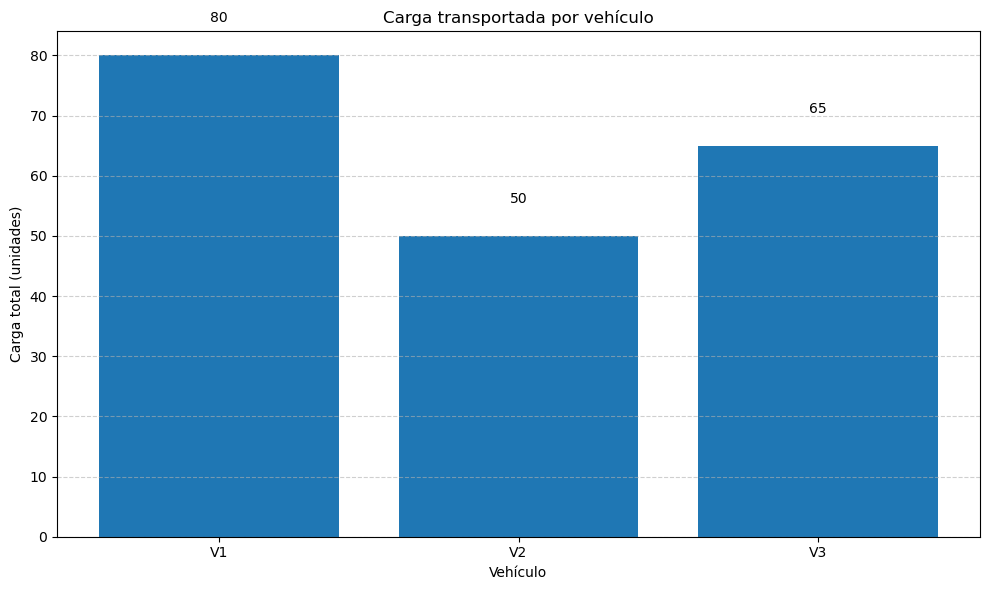

In [65]:
graficar_carga_por_vehiculo(modelo, "resultados/carga_por_vehiculo0.png")


In [66]:
generar_verificacion(
    modelo=modelo, 
    centros=centros,
    clientes=clientes,
    vehiculos=vehiculos,
    distancias=distancias,
    parametros=parametros,
    geometries=geometries, 
    nombre_archivo="resultados/verificacion_caso0.csv"
)


,VehicleId,DepotId,InitialLoad,RouteSequence,ClientsServed,DemandsSatisfied,TotalDistance,TotalTime,FuelCost
0,V1,CD1,80,CD1 - C2 - CD1,1,80,3.7279,8.94696,19571.475
1,V2,CD2,50,CD2 - C1 - CD2,1,50,6.7716,16.25184,35550.900
2,V3,CD1,65,CD1 - C3 - CD1,1,65,8.6026,20.64624,45163.650


## **Caso 1: CVRP Estándar**

### Carga de datos

In [67]:
vehicles1 = pd.read_csv('data/caso1/vehicles.csv')
vehicles1

,VehicleID,Capacity,Range
0,1,130,170
1,2,140,200
2,3,120,180
3,4,100,90
4,5,70,100
5,6,55,170
6,7,110,150
7,8,114,140


In [68]:
clients1 = pd.read_csv('data/caso1/clients.csv')
clients1

,ClientID,LocationID,Demand,Longitude,Latitude
0,1,2,13,-74.098938,4.597954
1,2,3,15,-74.075571,4.687821
2,3,4,12,-74.107085,4.709494
3,4,5,15,-74.097280,4.605029
4,5,6,20,-74.164641,4.648464
5,6,7,17,-74.120838,4.662137
6,7,8,17,-74.022131,4.697499
7,8,9,20,-74.172075,4.649417
8,9,10,20,-74.156153,4.606311
9,10,11,15,-74.090411,4.557380


In [69]:
depots1 = pd.read_csv('data/caso1/depots.csv')
depots1

,LocationID,DepotID,Longitude,Latitude
0,1,-74.153536,4.743359,NaN


### Transformaciones de los datos

Se transforman a diccionarios para que su tipo sea acorde con la implementacion de la clase del modelo.

In [70]:
depot = depots1.iloc[0]
centros1 = {
    "CD1": {
        "lat": depot["Longitude"],
        "lon": depot["DepotID"],     # ERROR DE ID
        "cap": 40000
    }
}

centros1

{'CD1': {'lat': np.float64(4.743359),
  'lon': np.float64(-74.153536),
  'cap': 40000}}

In [71]:
base_cap = vehicles1.iloc[0]["Capacity"]
base_rang = vehicles1.iloc[0]["Range"]

vehiculos1 = {f"V{v}": {"cap": base_cap, "rango": base_rang}
             for v in vehicles1["VehicleID"]}

vehiculos1

{'V1': {'cap': np.int64(130), 'rango': np.int64(170)},
 'V2': {'cap': np.int64(130), 'rango': np.int64(170)},
 'V3': {'cap': np.int64(130), 'rango': np.int64(170)},
 'V4': {'cap': np.int64(130), 'rango': np.int64(170)},
 'V5': {'cap': np.int64(130), 'rango': np.int64(170)},
 'V6': {'cap': np.int64(130), 'rango': np.int64(170)},
 'V7': {'cap': np.int64(130), 'rango': np.int64(170)},
 'V8': {'cap': np.int64(130), 'rango': np.int64(170)}}

In [72]:
clientes1 = {
    f"C{int(row['ClientID'])}": {
        "demanda": row["Demand"],
        "lat": row["Latitude"],
        "lon": row["Longitude"]
    }
    for _, row in clients1.iterrows()
}
clientes1

{'C1': {'demanda': np.float64(13.0),
  'lat': np.float64(4.59795431125545),
  'lon': np.float64(-74.09893796560621)},
 'C2': {'demanda': np.float64(15.0),
  'lat': np.float64(4.687820646838871),
  'lon': np.float64(-74.07557103763986)},
 'C3': {'demanda': np.float64(12.0),
  'lat': np.float64(4.70949446000624),
  'lon': np.float64(-74.10708524062704)},
 'C4': {'demanda': np.float64(15.0),
  'lat': np.float64(4.605029068682624),
  'lon': np.float64(-74.09727965657427)},
 'C5': {'demanda': np.float64(20.0),
  'lat': np.float64(4.648463876533332),
  'lon': np.float64(-74.16464148202755)},
 'C6': {'demanda': np.float64(17.0),
  'lat': np.float64(4.662137416953968),
  'lon': np.float64(-74.12083799988112)},
 'C7': {'demanda': np.float64(17.0),
  'lat': np.float64(4.697499030379109),
  'lon': np.float64(-74.02213076607309)},
 'C8': {'demanda': np.float64(20.0),
  'lat': np.float64(4.649416884236942),
  'lon': np.float64(-74.17207549744595)},
 'C9': {'demanda': np.float64(20.0),
  'lat': np.f

### Solucion del modelo

1. Se calculan distancias
2. Se crea la instancia del modelo
3. Se resuleve el modelo
4. Se presentan los resultados en consola y la Visualizacion en el mapa

In [73]:
# Distancias + geometría para visualización
distancias1, geometries1 = calcular_distancias_y_geometrias(centros1, clientes1, get_route_info)
#distancias1 = calcular_distancias_osrm(centros1,clientes1)

# Modelo
modelo1 = ModeloRuteoVRP_Planarizado(centros1, clientes1, vehiculos1, parametros, distancias1)
modelo1.resolver()
modelo1.imprimir_rutas()

Asignaciones ordenadas por vehículo:

Vehículo V1:
  - CD1 -> C6
  - C6 -> C18
  - C18 -> C17
  - C17 -> C4
  - C4 -> C15
  - C15 -> C22
  - C22 -> C13
  - C13 -> CD1

Vehículo V2:
  - CD1 -> C12
  - C12 -> CD1

Vehículo V3:
  - CD1 -> C19
  - C19 -> C21
  - C21 -> C7
  - C7 -> C2
  - C2 -> CD1

Vehículo V4:
  - CD1 -> C14
  - C14 -> CD1

Vehículo V5:
  - CD1 -> C3
  - C3 -> CD1

Vehículo V6:
  - CD1 -> C8
  - C8 -> C11
  - C11 -> C1
  - C1 -> C10
  - C10 -> C16
  - C16 -> C24
  - C24 -> C9
  - C9 -> C5
  - C5 -> CD1

Vehículo V7:
  - CD1 -> C20
  - C20 -> CD1

Vehículo V8:
  - CD1 -> C23
  - C23 -> CD1



In [74]:
colores1 = {
    'V1': 'red',
    'V2': 'orange',
    'V3': 'purple',
    'V4': 'blue',
    'V5': 'green',
    'V6': 'brown',
    'V7': 'cyan',
    'V8': 'magenta',
}

visualizar_rutas_folium(modelo1.model, centros1, clientes1, geometries1, colores1, nombre_archivo="./resultados/caso1_solucion.html" )

El mapa de rutas ha sido guardado en './resultados/caso1_solucion.html'.


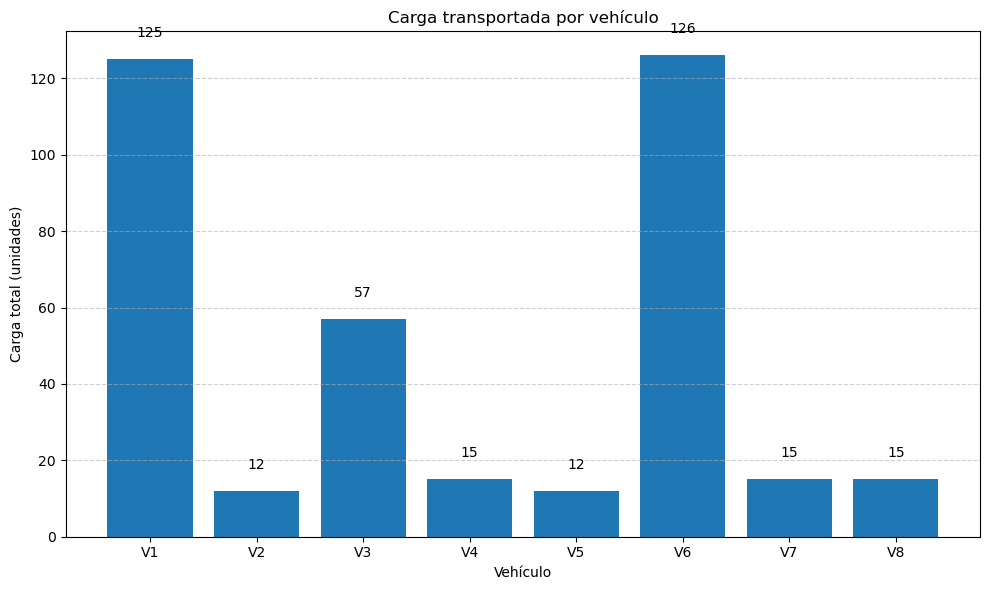

In [75]:
graficar_carga_por_vehiculo(modelo1, "resultados/carga_por_vehiculo1.png")

In [76]:
generar_verificacion(
    modelo=modelo1, 
    centros=centros1,
    clientes=clientes1,
    vehiculos=vehiculos1,
    distancias=distancias1,
    parametros=parametros,
    geometries=geometries1, 
    nombre_archivo="resultados/verificacion_caso1.csv"
)


,VehicleId,DepotId,InitialLoad,RouteSequence,ClientsServed,DemandsSatisfied,TotalDistance,TotalTime,FuelCost
0,V1,CD1,125.0,CD1 - C6 - C18 - C17 - C4 - C15 - C22 - C13 - CD1,7,17 - 12 - 25 - 15 - 17 - 18 - 21,51.0365,122.48760,267941.625
1,V2,CD1,12.0,CD1 - C12 - CD1,1,12,16.0837,38.60088,84439.425
2,V3,CD1,57.0,CD1 - C19 - C21 - C7 - C2 - CD1,4,11 - 14 - 17 - 15,41.1531,98.76744,216053.775
3,V4,CD1,15.0,CD1 - C14 - CD1,1,15,11.1015,26.64360,58282.875
4,V5,CD1,12.0,CD1 - C3 - CD1,1,12,13.6527,32.76648,71676.675
5,V6,CD1,126.0,CD1 - C8 - C11 - C1 - C10 - C16 - C24 - C9 - C...,8,20 - 17 - 13 - 15 - 10 - 11 - 20 - 20,75.5849,181.40376,396820.725
6,V7,CD1,15.0,CD1 - C20 - CD1,1,15,13.0423,31.30152,68472.075
7,V8,CD1,15.0,CD1 - C23 - CD1,1,15,12.1251,29.10024,63656.775


## **Caso 2: Múltiples Centros de Distribución**

### Carga de datos

In [77]:
vehicles2 = pd.read_csv("data/caso2/vehicles.csv")

vehicles2

,VehicleID,Capacity,Range
0,1,131.921140,145.852071
1,2,108.435620,1304.605971
2,3,91.504255,953.172609
3,4,32.896064,17.302304
4,5,22.652628,16.627680
5,6,22.682912,13.602811


In [78]:
clients2 = pd.read_csv("data/caso2/clients.csv")

clients2

,ClientID,LocationID,Demand,Longitude,Latitude
0,1,13,12,-74.196992,4.632553
1,2,14,15,-74.155037,4.601328
2,3,15,15,-74.101787,4.732421
3,4,16,6,-74.194862,4.638612
4,5,17,5,-74.110272,4.727692
5,6,18,11,-74.152289,4.665003
6,7,19,12,-74.032411,4.677102
7,8,20,10,-74.062476,4.707007
8,9,21,15,-74.098042,4.636075


In [79]:
depots2 = pd.read_csv("data/caso2/depots.csv")

depots2

,DepotID,LocationID,Longitude,Latitude,Capacity
0,1,1,-74.081242,4.750212,8
1,2,2,-74.109934,4.536383,10
2,3,3,-74.038548,4.792926,0
3,4,4,-74.067069,4.721678,4
4,5,5,-74.138263,4.607707,28
5,6,6,-74.124002,4.650463,3
6,7,7,-74.095619,4.621912,0
7,8,8,-74.109756,4.678961,10
8,9,9,-74.095472,4.735973,43
9,10,10,-74.109916,4.550641,1


### Transformaciones de los datos

Se transforman a diccionarios para que su tipo sea acorde con la implementacion de la clase del modelo.


In [80]:
centros2 = {
    f"CD{int(row['DepotID'])}" :{
        "lat": row["Latitude"],
        "lon": row["Longitude"],
        "cap": row["Capacity"]
    }
    for _, row in depots2.iterrows()
}

centros2


{'CD1': {'lat': np.float64(4.75021190869025),
  'lon': np.float64(-74.08124218159384),
  'cap': np.float64(8.0)},
 'CD2': {'lat': np.float64(4.5363832206427785),
  'lon': np.float64(-74.10993358606953),
  'cap': np.float64(10.0)},
 'CD3': {'lat': np.float64(4.792925960208614),
  'lon': np.float64(-74.03854814565923),
  'cap': np.float64(0.0)},
 'CD4': {'lat': np.float64(4.72167778077445),
  'lon': np.float64(-74.06706883098641),
  'cap': np.float64(4.0)},
 'CD5': {'lat': np.float64(4.607707046760958),
  'lon': np.float64(-74.13826337931849),
  'cap': np.float64(28.0)},
 'CD6': {'lat': np.float64(4.650463053612691),
  'lon': np.float64(-74.12400186370824),
  'cap': np.float64(3.0)},
 'CD7': {'lat': np.float64(4.621911772492814),
  'lon': np.float64(-74.09561875464892),
  'cap': np.float64(0.0)},
 'CD8': {'lat': np.float64(4.678960680833056),
  'lon': np.float64(-74.10975623736951),
  'cap': np.float64(10.0)},
 'CD9': {'lat': np.float64(4.735973062153282),
  'lon': np.float64(-74.0954723

In [81]:
vehiculos2 = {
    f"V{int(row['VehicleID'])}": {
        "cap": row["Capacity"],
        "rango": row["Range"]
    }
    for _, row in vehicles2.iterrows()
}

vehiculos2


{'V1': {'cap': np.float64(131.9211396722696),
  'rango': np.float64(145.85207096486445)},
 'V2': {'cap': np.float64(108.4356199315333),
  'rango': np.float64(1304.605971281605)},
 'V3': {'cap': np.float64(91.50425520531196),
  'rango': np.float64(953.172608610164)},
 'V4': {'cap': np.float64(32.896064077536955),
  'rango': np.float64(17.302304187458727)},
 'V5': {'cap': np.float64(22.65262807032524),
  'rango': np.float64(16.627680130757895)},
 'V6': {'cap': np.float64(22.682911535937688),
  'rango': np.float64(13.602810739289229)}}

In [82]:
clientes2 = {
    f"C{int(row['ClientID'])}": {
        "demanda": row["Demand"],
        "lat": row["Latitude"],
        "lon": row["Longitude"]
    }
    for _, row in clients2.iterrows()
}

clientes2

{'C1': {'demanda': np.float64(12.0),
  'lat': np.float64(4.632552840424734),
  'lon': np.float64(-74.19699184741948)},
 'C2': {'demanda': np.float64(15.0),
  'lat': np.float64(4.601328214582278),
  'lon': np.float64(-74.15503659129905)},
 'C3': {'demanda': np.float64(15.0),
  'lat': np.float64(4.732421040989568),
  'lon': np.float64(-74.10178731827096)},
 'C4': {'demanda': np.float64(6.0),
  'lat': np.float64(4.638612189685843),
  'lon': np.float64(-74.19486224157397)},
 'C5': {'demanda': np.float64(5.0),
  'lat': np.float64(4.727691608175209),
  'lon': np.float64(-74.11027242131048)},
 'C6': {'demanda': np.float64(11.0),
  'lat': np.float64(4.665002925306577),
  'lon': np.float64(-74.15228946899238)},
 'C7': {'demanda': np.float64(12.0),
  'lat': np.float64(4.6771016997028205),
  'lon': np.float64(-74.03241075805882)},
 'C8': {'demanda': np.float64(10.0),
  'lat': np.float64(4.707007012114083),
  'lon': np.float64(-74.0624758742746)},
 'C9': {'demanda': np.float64(15.0),
  'lat': np.f

### Solucion del modelo

1. Se calculan distancias
2. Se crea la instancia del modelo
3. Se resuleve el modelo
4. Se presentan los resultados en consola y la Visualizacion en el mapa

In [83]:
# Distancias + geometría para visualización
distancias2, geometries2 = calcular_distancias_y_geometrias(centros2, clientes2, get_route_info)
#distancias2 = calcular_distancias_osrm(centros2,clientes2)

# Modelo
modelo2 = ModeloRuteoVRP_Planarizado(centros2, clientes2, vehiculos2, parametros, distancias2)
modelo2.resolver()
modelo2.imprimir_rutas()

Asignaciones ordenadas por vehículo:

Vehículo V1:
  - CD9 -> C3
  - C3 -> CD9

Vehículo V2:
  - CD9 -> C8
  - C8 -> C7
  - C7 -> CD4

Vehículo V3:
  - CD5 -> C1
  - C1 -> C4
  - C4 -> C6
  - C6 -> CD6

Vehículo V4:
  - CD9 -> C5
  - C5 -> CD8

Vehículo V5:
  - CD11 -> C9
  - C9 -> CD7

Vehículo V6:
  - CD5 -> C2
  - C2 -> CD5



In [84]:
colores2 = {
    'V1': 'red',
    'V2': 'orange',
    'V3': 'purple',
    'V4': 'blue',
    'V5': 'green',
    'V6': 'cyan'
}

visualizar_rutas_folium(modelo2.model, centros2, clientes2, geometries2, colores2, nombre_archivo="./resultados/caso2_solucion.html" )

El mapa de rutas ha sido guardado en './resultados/caso2_solucion.html'.


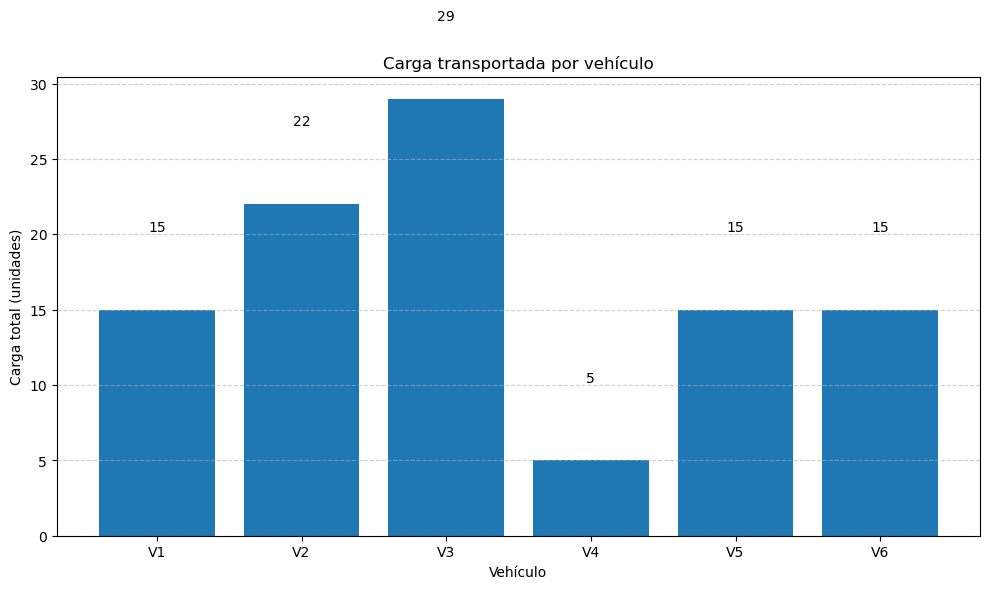

In [85]:
graficar_carga_por_vehiculo(modelo2, "resultados/carga_por_vehiculo2.png")

In [86]:
generar_verificacion(
    modelo=modelo2, 
    centros=centros2,
    clientes=clientes2,
    vehiculos=vehiculos2,
    distancias=distancias2,
    parametros=parametros,
    geometries=geometries2, 
    nombre_archivo="resultados/verificacion_caso2.csv"
)

,VehicleId,DepotId,InitialLoad,RouteSequence,ClientsServed,DemandsSatisfied,TotalDistance,TotalTime,FuelCost
0,V1,CD9,15.0,CD9 - C3 - CD9,1,15,1.2319,2.95656,6467.475
1,V2,CD9,22.0,CD9 - C8 - C7 - CD4,2,10 - 12,21.7508,52.20192,114191.700
2,V3,CD5,29.0,CD5 - C1 - C4 - C6 - CD6,3,12 - 6 - 11,21.4899,51.57576,112821.975
3,V4,CD9,5.0,CD9 - C5 - CD8,1,5,8.1285,19.50840,42674.625
4,V5,CD11,15.0,CD11 - C9 - CD7,1,15,2.3673,5.68152,12428.325
5,V6,CD5,15.0,CD5 - C2 - CD5,1,15,2.9701,7.12824,15593.025


## **Caso 3: Escenario Realista**

###  Modelo

In [ ]:
from pyomo.environ import *

class ModeloRuteoVRP_Planarizado_3:
    def __init__(self, centros, clientes, vehiculos, parametros, distancias):
        self.centros = centros
        self.clientes = clientes
        self.vehiculos = vehiculos
        self.parametros = parametros
        self.distancias = distancias
        self.model = ConcreteModel()
        self._build_model()

    def _build_model(self):
        model = self.model
        centros = self.centros
        clientes = self.clientes
        vehiculos = self.vehiculos
        distancias = self.distancias
        nodos = list(centros.keys()) + list(clientes.keys())

        # Conjuntos
        model.N = Set(initialize=nodos)
        model.C = Set(initialize=clientes.keys())
        model.D = Set(initialize=centros.keys())
        model.V = Set(initialize=vehiculos.keys())
        model.A = Set(
            within=(model.D | model.C) * (model.D | model.C),
            initialize=[(i, j) for i in (set(centros.keys()) | set(clientes.keys()))
                        for j in (set(centros.keys()) | set(clientes.keys()))
                        if i != j and not (i in centros and j in centros)]
        )

        # Parámetros
        model.dem_c = Param(model.C, initialize={c: clientes[c]["demanda"] for c in clientes})
        model.dist_ij = Param(model.A, initialize=distancias)
        model.cap_v = Param(model.V, initialize={v: vehiculos[v]["cap"] for v in vehiculos})
        model.rang_v = Param(model.V, initialize={v: vehiculos[v]["rango"] for v in vehiculos})
        model.cap_d = Param(model.D, initialize={d: centros[d]["cap"] for d in centros})

        # Variables
        model.x = Var(model.A, model.V, within=Binary)
        model.u = Var(model.C, model.V, within=NonNegativeIntegers, bounds=(0, len(model.C | model.D) - 1))

        # Función objetivo
        def funcion_objetivo(model):
            return sum(model.x[i, j, v] * model.dist_ij[i, j] *
                       (self.parametros["Ft"] + self.parametros["Cm"] + self.parametros["RC"] * self.parametros["Pf"])
                       for v in model.V for (i, j) in model.A)
        model.objetivo = Objective(rule=funcion_objetivo, sense=minimize)

        # Restricción 1: capacidad de centros
        def capacidad_distribucion_rule(model, d):
            return sum(model.x[d, c, v] * model.dem_c[c] for c in model.C for v in model.V) <= model.cap_d[d]
        model.capacidad_distribucion = Constraint(model.D, rule=capacidad_distribucion_rule)

        # Restricción 2: capacidad de vehículos
        def capacidad_vehiculos_rule(model, v):
            return sum(model.x[i, c, v] * model.dem_c[c] for (i, c) in model.A if c in model.C) <= model.cap_v[v]
        model.capacidad_vehiculos = Constraint(model.V, rule=capacidad_vehiculos_rule)

        # Restricción 3: todos los clientes deben ser visitados
        def visitar_clientes_rule(model, c):
            return sum(model.x[i, c, v] for v in model.V for i in nodos if (i, c) in model.A) == 1
        model.visitar_clientes = Constraint(model.C, rule=visitar_clientes_rule)

        # Restricción 4: autonomía de vehículos
        def autonomia_vehiculos_rule(model, v):
            return sum(model.dist_ij[i, j] * model.x[i, j, v] for (i, j) in model.A) <= model.rang_v[v]
        model.autonomia_vehiculos = Constraint(model.V, rule=autonomia_vehiculos_rule)

        # Restricción 5: conservación del flujo
        def conservacion_flujo_rule(model, i, v):
            salida = sum(model.x[i, j, v] for j in nodos if (i, j) in model.A)
            entrada = sum(model.x[j, i, v] for j in nodos if (j, i) in model.A)
            return salida - entrada == 0 if i in model.C else salida - entrada <= 1
        model.conservacion_flujo = Constraint(nodos, model.V, rule=conservacion_flujo_rule)

        # Restricción 6: eliminación de subrutas
        def subtours_elimination_rule(model, i, j, v):
            if i != j and i in model.C and j in model.C:
                return model.u[i, v] - model.u[j, v] + len(nodos) * model.x[i, j, v] <= len(nodos) - 1
            else:
                return Constraint.Skip
        model.subtours_elimination = Constraint(model.C, model.C, model.V, rule=subtours_elimination_rule)

        # Restricción 7: salida única desde el centro
        def salida_unica_rule(model, v):
            return sum(model.x[d, j, v] for d in model.D for j in model.C if (d, j) in model.A) == 1
        model.salida_unica = Constraint(model.V, rule=salida_unica_rule)

        # Restricción 8: retorno obligatorio a algún centro
        def retorno_centro_rule(model, v):
            return sum(model.x[i, d, v] for d in model.D for i in model.C if (i, d) in model.A) >= 1
        model.retorno_centro = Constraint(model.V, rule=retorno_centro_rule)


    def resolver(self, solver_name="highs"):
        solver = SolverFactory(solver_name)
        return solver.solve(self.model, timelimit = 600)

    def imprimir_rutas(self):
        model = self.model
        print("Asignaciones ordenadas por vehículo:\n")
        for v in model.V:
            salida = [(i,j) for (i,j) in model.A
                    if i in model.D and model.x[i,j,v].value == 1]
            if not salida:
                print(f"Vehículo {v}: no sale de ningún centro")
                continue

            start_arc = salida[0]
            ruta = [ start_arc[0] ]
            actual = start_arc[1]
            ruta.append(actual)

            while actual not in model.D:
                siguiente = next((j for (i,j) in model.A
                                if i==actual and model.x[i,j,v].value == 1),
                                None)
                if siguiente is None:
                    break
                ruta.append(siguiente)
                actual = siguiente

            print(f"Vehículo {v}:")
            for u, w in zip(ruta, ruta[1:]):
                print(f"  - {u} -> {w}")
            print()


### Carga de datos

In [150]:
vehicles3 = pd.read_csv("data/caso3/vehicles.csv")

vehicles3

,VehicleID,Capacity,Range
0,1,132,146
1,2,136,196
2,3,115,143
3,4,158,174
4,5,109,167
5,6,109,137
6,7,126,93
7,8,79,134
8,9,96,160
9,10,99,108


In [151]:
clients3 = pd.read_csv("data/caso3/clients.csv")

clients3

,ClientID,locationID,Demand,Longitude,Latitude
0,1,12,12,-74.150806,4.679769
1,2,13,12,-74.017996,4.733831
2,3,14,12,-74.143655,4.620928
3,4,15,12,-74.034583,4.733074
4,5,16,12,-74.055887,4.820900
...,...,...,...,...,...
85,86,97,12,-74.075137,4.547407
86,87,98,10,-74.162648,4.659240
87,88,99,12,-74.147008,4.564126
88,89,100,12,-74.073188,4.579649


In [152]:
depots3 = pd.read_csv("data/caso3/depots.csv")

depots3

,DepotID,LocationID,Longitude,Latitude,Capacity
0,1,1,-74.081242,4.750212,11
1,2,2,-74.109934,4.536383,90
2,3,3,-74.038548,4.792926,130
3,4,4,-74.067069,4.721678,145
4,5,5,-74.138263,4.607707,260
5,6,6,-74.124002,4.650463,180
6,7,7,-74.095619,4.621912,720
7,8,8,-74.109756,4.678961,55
8,9,9,-74.095472,4.735973,70
9,10,10,-74.109916,4.550641,75


### Transformaciones de los datos

Se transforman a diccionarios para que su tipo sea acorde con la implementacion de la clase del modelo.

In [157]:
centros3 = {
    f"CD{int(row['DepotID'])}" :{
        "lat": row["Latitude"],
        "lon": row["Longitude"],
        "cap": row["Capacity"]
    }
    for _, row in depots3.iterrows()
}

centros3


{'CD1': {'lat': np.float64(4.75021190869025),
  'lon': np.float64(-74.08124218159384),
  'cap': np.float64(11.0)},
 'CD2': {'lat': np.float64(4.5363832206427785),
  'lon': np.float64(-74.10993358606953),
  'cap': np.float64(90.0)},
 'CD3': {'lat': np.float64(4.792925960208614),
  'lon': np.float64(-74.03854814565923),
  'cap': np.float64(130.0)},
 'CD4': {'lat': np.float64(4.72167778077445),
  'lon': np.float64(-74.06706883098641),
  'cap': np.float64(145.0)},
 'CD5': {'lat': np.float64(4.607707046760958),
  'lon': np.float64(-74.13826337931849),
  'cap': np.float64(260.0)},
 'CD6': {'lat': np.float64(4.650463053612691),
  'lon': np.float64(-74.12400186370824),
  'cap': np.float64(180.0)},
 'CD7': {'lat': np.float64(4.621911772492814),
  'lon': np.float64(-74.09561875464892),
  'cap': np.float64(720.0)},
 'CD8': {'lat': np.float64(4.678960680833056),
  'lon': np.float64(-74.10975623736951),
  'cap': np.float64(55.0)},
 'CD9': {'lat': np.float64(4.735973062153282),
  'lon': np.float64(-

In [158]:
vehiculos3 = {
    f"V{int(row['VehicleID'])}": {
        "cap": row["Capacity"],
        "rango": row["Range"]
    }
    for _, row in vehicles3.iterrows()
}

vehiculos3


{'V1': {'cap': np.int64(132), 'rango': np.int64(146)},
 'V2': {'cap': np.int64(136), 'rango': np.int64(196)},
 'V3': {'cap': np.int64(115), 'rango': np.int64(143)},
 'V4': {'cap': np.int64(158), 'rango': np.int64(174)},
 'V5': {'cap': np.int64(109), 'rango': np.int64(167)},
 'V6': {'cap': np.int64(109), 'rango': np.int64(137)},
 'V7': {'cap': np.int64(126), 'rango': np.int64(93)},
 'V8': {'cap': np.int64(79), 'rango': np.int64(134)},
 'V9': {'cap': np.int64(96), 'rango': np.int64(160)},
 'V10': {'cap': np.int64(99), 'rango': np.int64(108)},
 'V11': {'cap': np.int64(125), 'rango': np.int64(955)},
 'V12': {'cap': np.int64(98), 'rango': np.int64(716)},
 'V13': {'cap': np.int64(86), 'rango': np.int64(1023)},
 'V14': {'cap': np.int64(74), 'rango': np.int64(1076)},
 'V15': {'cap': np.int64(85), 'rango': np.int64(942)},
 'V16': {'cap': np.int64(22), 'rango': np.int64(21)},
 'V17': {'cap': np.int64(25), 'rango': np.int64(12)},
 'V18': {'cap': np.int64(30), 'rango': np.int64(12)},
 'V19': {'cap

In [159]:
clientes3 = {
    f"C{int(row['ClientID'])}": {
        "demanda": row["Demand"],
        "lat": row["Latitude"],
        "lon": row["Longitude"]
    }
    for _, row in clients3.iterrows()
}

clientes3

{'C1': {'demanda': np.float64(12.0),
  'lat': np.float64(4.679769454542633),
  'lon': np.float64(-74.15080587752655)},
 'C2': {'demanda': np.float64(12.0),
  'lat': np.float64(4.733830991590818),
  'lon': np.float64(-74.01799606682779)},
 'C3': {'demanda': np.float64(12.0),
  'lat': np.float64(4.620928444870193),
  'lon': np.float64(-74.14365528529937)},
 'C4': {'demanda': np.float64(12.0),
  'lat': np.float64(4.7330740665555),
  'lon': np.float64(-74.03458280137461)},
 'C5': {'demanda': np.float64(12.0),
  'lat': np.float64(4.820900231096688),
  'lon': np.float64(-74.05588712830665)},
 'C6': {'demanda': np.float64(12.0),
  'lat': np.float64(4.779275206620083),
  'lon': np.float64(-74.04633863054056)},
 'C7': {'demanda': np.float64(12.0),
  'lat': np.float64(4.723527744298546),
  'lon': np.float64(-74.06470768583738)},
 'C8': {'demanda': np.float64(12.0),
  'lat': np.float64(4.551786739961474),
  'lon': np.float64(-74.16228381122208)},
 'C9': {'demanda': np.float64(12.0),
  'lat': np.f

### Solucion del modelo

1. Se calculan distancias
2. Se crea la instancia del modelo
3. Se resuleve el modelo
4. Se presentan los resultados en consola y la Visualizacion en el mapa

In [160]:
# Distancias + geometría para visualización
distancias3, geometries3 = calcular_distancias_y_geometrias(centros3, clientes3, get_route_info)
#distancias3 = calcular_distancias_osrm(centros3,clientes3)

# Modelo
modelo3 = ModeloRuteoVRP_Planarizado(centros3, clientes3, vehiculos3, parametros, distancias3)
modelo3.resolver()
modelo3.imprimir_rutas()

TimeoutExpired: Command '['/home/trodriten/anaconda3/envs/mos/bin/glpsol', '--tmlim', '450', '--write', '/tmp/tmpfzmtr1nu.glpk.raw', '--wglp', '/tmp/tmpdlmtofo5.glpk.glp', '--cpxlp', '/tmp/tmp8bx8fr80.pyomo.lp']' timed out after 454.4999896070003 seconds

In [ ]:
# TODO: Adapatar al caso 3 los colores

colores3 = {
    'V1': 'red',
    'V2': 'orange',
    'V3': 'purple',
    'V4': 'blue',
    'V5': 'green',
    'V6': 'cyan'
}

visualizar_rutas_folium(modelo3.model, centros3, clientes3, geometries3, colores3, nombre_archivo="./resultados/caso3_solucion.html" )

## Conclusiones